!pip install git+https://github.com/amazon-science/chronos-forecasting.git

In [34]:
# Lib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

In [35]:
# Load the time series data
df = pd.read_csv("../epidemic_curve.csv")
df.head()


,date,cases
0,2024-01-01,0
1,2024-01-08,0
2,2024-01-15,46
3,2024-01-22,40
4,2024-01-29,3


In [36]:
df["date"] = pd.to_datetime(df["date"])

In [37]:
# give the row index for 2024-05-27
target_date = "2024-05-27"
split_idx = df[df["date"] == target_date].index[0]


#### Use data before 2024-05-27 date for context (i.e., training)

In [38]:
# Prepare the data for Chronos
'''
Extract the numeric series (the cases column) and convert it to a PyTorch tensor. 

Chronos expects a 1D tensor (or a batch of 1D tensors) as input.
'''
train_data = df["cases"].iloc[:split_idx + 1]  # include the week of 2024-05-27

context=torch.tensor(train_data.values, dtype=torch.float32)

In [39]:
context.shape # This creates context, a 1D tensor of length 40 (for 40 weeks)

torch.Size([22])

In [40]:
# Load the pre-trained Chronos model
'''
Use ChronosPipeline.from_pretrained to load the Chronos-T5 model.

The resulting pipeline object encapsulates the model and will be used for prediction.
'''
pipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-large", device_map="mps") # This will download the amazon/chronos-t5-small model and initialize a forecasting pipeline
# Also i can use device_map="auto" to use GPU if available or device_map="mps" for my MacBook laptop

'''
We can switch to chronos-t5-large or any other model just by changing the model name.
For example:
Pipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-large", device_map="mps")
                (or)
Pipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-base", device_map="mps")
                (or)
Pipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-small", device_map="mps")
                ...

                
'''


'\nWe can switch to chronos-t5-large or any other model just by changing the model name.\nFor example:\nPipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-large", device_map="mps")\n                (or)\nPipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-base", device_map="mps")\n                (or)\nPipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-small", device_map="mps")\n                ...\n\n\n'

#### Forecast the next 4 weeks

In [41]:
# Forecast the next 4 weeks
'''
Call pipeline.predict with the context tensor and prediction_length=4 to forecast the next 4 time steps.
'''

prediction_length = 4 # We want to forecast the next 4 weeks
forecast = pipeline.predict(context, prediction_length) # shape [num_series, num_samples, prediction_length]


In [42]:
forecast.shape # This creates forecast, a 1D tensor of length 4 (for 4 predicted weeks)

torch.Size([1, 20, 4])

This runs the model to predict 4 future weekly values. Internally, Chronos generates many sample trajectories; as shown above, the output forecast will have shape `[num_series, num_samples, prediction_length]`. 

Here **num_series=1 (one time series)** and **prediction_length=4**. 

For example, if the default num_samples is 20, then forecast.shape would be (1, 20, 4).

In [43]:
forecast[0] # (shape [num_samples, 4]) to see all sampled forecasts. The predicted values for the next 4 weeks

tensor([[1794.7000, 1717.0448, 1721.3590, 1596.2477],
        [1773.1292, 1635.0752, 1453.8796, 1333.0825],
        [1863.7271, 1859.4128, 1807.6426, 1721.3590],
        [1850.7844, 1898.2405, 1911.1830, 1967.2673],
        [1803.3284, 1811.9567, 1807.6426, 1846.4703],
        [1850.7844, 1842.1561, 1885.2979, 1885.2979],
        [1880.9838, 1850.7844, 1803.3284, 1803.3284],
        [1781.7574, 1691.1597, 1566.0483, 1449.5654],
        [1846.4703, 1876.6696, 1885.2979, 1932.7539],
        [1941.3822, 1906.8688, 1811.9567, 1751.5582],
        [1790.3859, 1777.4432, 1773.1292, 1764.5007],
        [1889.6121, 1859.4128, 1816.2709, 1708.4164],
        [1799.0142, 1682.5312, 1518.5923, 1246.7990],
        [1906.8688, 1902.5546, 1889.6121, 1915.4972],
        [1855.0986, 1855.0986, 1880.9838, 1833.5277],
        [1937.0680, 2001.7809, 1950.0106, 1893.9263],
        [1773.1292, 1755.8724, 1682.5312, 1561.7343],
        [1846.4703, 1717.0448, 1695.4739, 1648.0178],
        [1803.3284, 1678.217

In [44]:
# Chronos produces a distribution of future values
# Visualize the forecast

#forecast_index = range(len(df), len(df) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

print("Low (10th percentile) forecast for next 4 weeks:", low)
print("Median (50th percentile) forecast for next 4 weeks:", median)
print("High (90th percentile) forecast for next 4 weeks:", high)


Low (10th percentile) forecast for next 4 weeks: [1780.8946167  1682.0998291  1545.77169189 1375.79285889]
Median (50th percentile) forecast for next 4 weeks: [1848.62738037 1839.99902344 1805.48547363 1736.45861816]
High (90th percentile) forecast for next 4 weeks: [1909.88869629 1902.98598633 1891.76915283 1917.22286377]


#### Create forecast dates starting from the week after 2024-05-27

In [45]:
start_date = pd.to_datetime("2024-06-03")  # week after May 27
forecast_dates = pd.date_range(start=start_date, periods=4, freq="W-MON")


In [46]:
# Print forecasted 4 weeks with dates
print("\nForecasted Cases (Next 4 Weeks after 2024-05-27):")
for d, c in zip(forecast_dates, median):
    print(f"{d.strftime('%Y-%m-%d')}: {round(c, 2)} cases")


Forecasted Cases (Next 4 Weeks after 2024-05-27):
2024-06-03: 1848.63 cases
2024-06-10: 1840.0 cases
2024-06-17: 1805.49 cases
2024-06-24: 1736.46 cases


####  Plot the historical data and the forecast

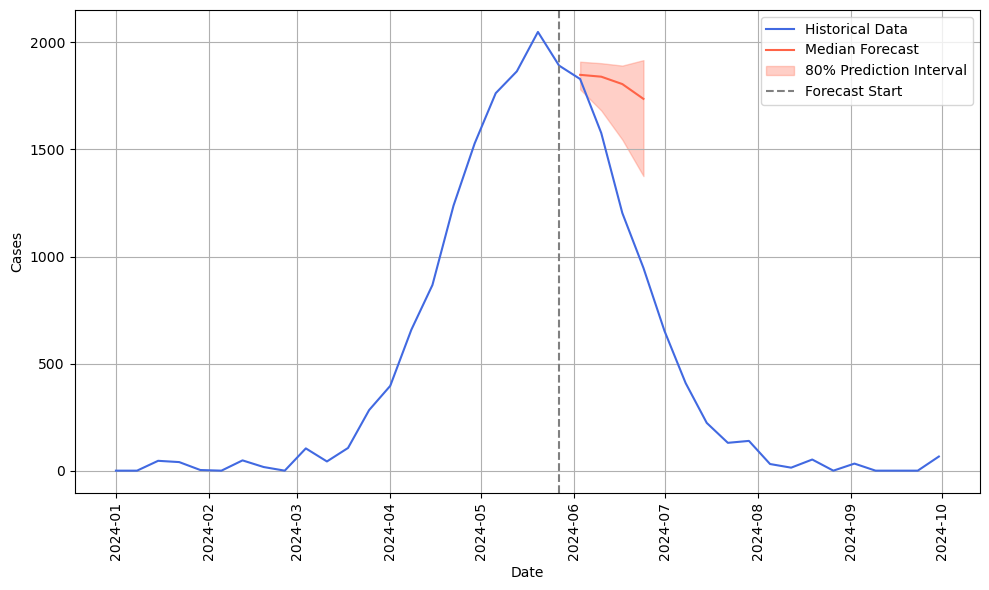

In [47]:
# Plot the historical data and the forecast
plt.figure(figsize=(10, 6))
plt.plot(df["date"], df["cases"], color="royalblue", label="Historical Data")
plt.plot(forecast_dates, median, color="tomato", label="Median Forecast")
plt.fill_between(forecast_dates, low, high, color="tomato", alpha=0.3, label="80% Prediction Interval")

# Add vertical line to indicate the start of the forecast
plt.axvline(pd.to_datetime("2024-05-27"), color="gray", linestyle="--", label="Forecast Start")

plt.xlabel("Date")
plt.xticks(rotation=90)

plt.ylabel("Cases")

plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

#### Evaluate Chronos with MAE, RMSE, $R^2$

In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 1. We already have split_idx from before but again for clarity
target_date = "2024-05-27"
split_idx = df[df["date"] == target_date].index[0]

# Step 2. Create train/test split based on that index
train_data = df["cases"].iloc[:split_idx + 1]  # includes 2024-05-27
test_data = df["cases"].iloc[split_idx + 1 : split_idx + 1 + prediction_length]

# Step3. Prepare context
context_train = torch.tensor(train_data.values, dtype=torch.float32)

# Step 4. Forecast
forecast = pipeline.predict(context_train, prediction_length=prediction_length)
median_forecast = np.quantile(forecast[0].numpy(), 0.5, axis=0)

# Step 5. Evaluate
y_true = test_data.values
y_pred = median_forecast

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_true, y_pred)

In [49]:
# Step 6: Print results
print("Evaluation on 4 Weeks After 2024-05-27")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.2f}")

Evaluation on 4 Weeks After 2024-05-27
MAE:  335.59
RMSE: 424.11
R²:   -0.57


In [50]:
print("GPU available:", torch.cuda.is_available())

GPU available: False
